In [1]:
import tensorflow as tf
from keras import layers, Model
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
# tf.config.experimental.reset_memory_stats(gpu, True)

tf.config.run_functions_eagerly(True)

from keras.callbacks import Callback

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, ConvLSTM1D, LSTM

from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [71]:
my_data = pd.read_csv('HarrisCounty/ForGAN/JulAug.csv')
ds_w = []
ds_e = []
for c in my_data.columns:
    if 'weekday' in c:
        ds_w.append(my_data[c].values)
    else:
        ds_e.append(my_data[c].values)

max_w =  np.max(ds_w)
max_e = np.max(ds_e)
ds_w = np.divide(ds_w, 1.1 * max_w)
ds_e = np.divide(ds_e, 1.1 * max_e)
ds_w1 = ds_w
ds_w = tf.data.Dataset.from_tensor_slices(ds_w)
ds_e = tf.data.Dataset.from_tensor_slices(ds_e)


In [54]:
ds_w.as_numpy_iterator().next().shape


(96,)

### Prepare data to feed into GAN

In [72]:
batch_size = 15
ds_w = ds_w.cache()
ds_w = ds_w.shuffle(1000)
ds_w = ds_w.batch(batch_size)
ds_w = ds_w.prefetch(64)

## Generator Discriminator Training

In [105]:
g_relu = 0.1
lstm_unit = 5
def build_generator():
    model = Sequential()
    model.add(LSTM(lstm_unit, activation='tanh', return_sequences=True,
               input_shape=(96, batch_size)))  # returns a sequence of vectors of dimension lstm_unit
    model.add(LeakyReLU(d_relu))

    model.add(LSTM(lstm_unit, return_sequences=True))  # returns a sequence of vectors of dimension lstm_unit
    model.add(LeakyReLU(d_relu))

    model.add(Dense(1, activation='sigmoid'))
    return model
generator = build_generator()
generator.summary()
# plt.plot(generator.predict(np.random.randn(1, 96, 15))[0])
#plt.plot(series[0].reshape([96]))

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 96, 5)             420       
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 96, 5)             0         
                                                                 
 lstm_73 (LSTM)              (None, 96, 5)             220       
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 96, 5)             0         
                                                                 
 dense_37 (Dense)            (None, 96, 1)             6         
                                                                 
Total params: 646
Trainable params: 646
Non-trainable params: 0
_________________________________________________________________


In [106]:
d_relu = 0.1
d_dropout = 0.2
def build_discriminator():
    model = Sequential()

    model.add(LSTM(lstm_unit, return_sequences=True,
               input_shape=(96, 1)))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(LSTM(lstm_unit, return_sequences=True,
               input_shape=(96, 1)))
    model.add(Flatten())
    #model.add(Dropout(d_dropout))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()
# Single prediction needs np.expand_dims(series[0], 0)
# discriminator.predict(ds_w.as_numpy_iterator().next())

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 96, 5)             140       
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 96, 5)             0         
                                                                 
 dropout_41 (Dropout)        (None, 96, 5)             0         
                                                                 
 lstm_75 (LSTM)              (None, 96, 5)             220       
                                                                 
 flatten_18 (Flatten)        (None, 480)               0         
                                                                 
 dense_38 (Dense)            (None, 1)                 481       
                                                                 
Total params: 841
Trainable params: 841
Non-trainable

In [107]:
g_a, d_a = 0.0001, 0.00001
g_opt = Adam(learning_rate=g_a)
d_opt = Adam(learning_rate=d_a)  # Does not learn too fast
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
class LoadGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compilee(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_series = batch
        fake_series = self.generator(tf.random.normal((batch_size, 96, batch_size)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images
            yhat_real = self.discriminator(real_series, training=True)
            yhat_fake = self.discriminator(fake_series, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake series
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)


            # pass through and add some noise to the outputs
            noise_real = 0.2*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.2*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            # generate same new images
            gen_series = self.generator(tf.random.normal((batch_size, 96, batch_size)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_series, training=False)

            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
loadgan = LoadGAN(generator, discriminator)
loadgan.compilee(g_opt, d_opt, g_loss, d_loss)

#### Call Back

In [108]:
class ModelMonitor(Callback):
    def __init__(self, num_img=4, latent_dim=batch_size):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vector = tf.random.normal((self.num_img, 96, self.latent_dim))
        generated_series = self.model.generator(random_latent_vector)
        generated_series *= max_w
        generated_series.numpy()
        for i in range(self.num_img):
            serie = generated_series[i]
            #serie.save(os.path.join('series', f'generated_img_{epoch}_{i}.png'))

#### Train

In [109]:
hist = loadgan.fit(ds_w, epochs=100, callbacks=[ModelMonitor()])

Epoch 1/100
13/13 [==============================] - 30s 2s/step - d_loss: 0.6915 - g_loss: 0.7214
Epoch 2/100
13/13 [==============================] - 28s 2s/step - d_loss: 0.6910 - g_loss: 0.7228
Epoch 3/100
13/13 [==============================] - 28s 2s/step - d_loss: 0.6906 - g_loss: 0.7244
Epoch 4/100
13/13 [==============================] - 24s 2s/step - d_loss: 0.6904 - g_loss: 0.7259
Epoch 5/100
13/13 [==============================] - 21s 2s/step - d_loss: 0.6896 - g_loss: 0.7276
Epoch 6/100
13/13 [==============================] - 22s 2s/step - d_loss: 0.6899 - g_loss: 0.7291
Epoch 7/100
13/13 [==============================] - 28s 2s/step - d_loss: 0.6892 - g_loss: 0.7308
Epoch 8/100
13/13 [==============================] - 28s 2s/step - d_loss: 0.6889 - g_loss: 0.7323
Epoch 9/100
13/13 [==============================] - 30s 2s/step - d_loss: 0.6883 - g_loss: 0.7339
Epoch 10/100
13/13 [==============================] - 28s 2s/step - d_loss: 0.6887 - g_loss: 0.7356
Epoch 11/

In [104]:
normal_noise = tf.random.normal((4, 96, 15))
series = generator.predict(normal_noise)
resolution = 24*4
ticks = []
'''for i in range(resolution):
    if i%4 == 0:
        ticks.append(str(int(i/4)))
    else:
        ticks.append('')'''

fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
for s in series:
    ax[0].plot(range(resolution), np.multiply(s.reshape([resolution]), max_w), linewidth=1)
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Generated Power Consumption')
ax[0].set_xticks(range(resolution), ticks)

ax[1].plot(my_data[[c for c in my_data.columns[:30] if 'weekday' in c]], linewidth=1)
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Historical Power Consumption')
ax[1].set_xticks(range(resolution), ticks)
plt.show()
#plt.savefig(f'../HarrisCounty/IMG/Batch {batch_size}-g_a {g_a}-d_a {d_a}-relu {g_relu}-dropout {d_dropout}.jpg')

C:\Users\Feri\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: Exception encountered when calling layer 'sequential_36' (type Sequential).

Input 0 of layer "lstm_67" is incompatible with the layer: expected shape=(None, None, 15), found shape=(4, 96, 1)

Call arguments received by layer 'sequential_36' (type Sequential):
  • inputs=tf.Tensor(shape=(4, 96, 1), dtype=float32)
  • training=False
  • mask=None

In [87]:
ds_w.as_numpy_iterator().next()[0]

array([0.27908119, 0.2759418 , 0.27463341, 0.27405271, 0.27432569,
       0.27313007, 0.27858002, 0.27364891, 0.27608115, 0.27181148,
       0.27016231, 0.27060353, 0.27004301, 0.26987569, 0.27066322,
       0.27330752, 0.2778053 , 0.28101921, 0.28935684, 0.29437885,
       0.30389723, 0.33307793, 0.34405041, 0.36289508, 0.38296953,
       0.3904404 , 0.30405398, 0.32075887, 0.33629515, 0.33731308,
       0.35428984, 0.36416878, 0.38175299, 0.387709  , 0.40770009,
       0.41751363, 0.50162191, 0.47434448, 0.52666341, 0.53291421,
       0.56093852, 0.58824933, 0.60970465, 0.64027751, 0.65239148,
       0.66913008, 0.67112885, 0.67677692, 0.68230252, 0.69032767,
       0.69878317, 0.70485187, 0.7038729 , 0.70826203, 0.71423653,
       0.7212561 , 0.72012173, 0.72302043, 0.71559406, 0.70867889,
       0.69856939, 0.69000608, 0.65998895, 0.63536303, 0.62621779,
       0.61607444, 0.58153808, 0.570353  , 0.53930612, 0.50313002,
       0.48843719, 0.4723261 , 0.46238534, 0.44552964, 0.40714

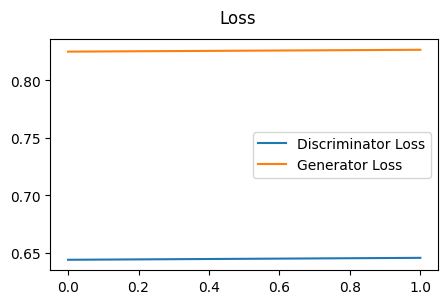

In [98]:
plt.figure(figsize=(5, 3), dpi=100)
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='Discriminator Loss')
plt.plot(hist.history['g_loss'], label='Generator Loss')
plt.legend()
plt.show()

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')